# **Déscription des points décisionnels**
## **Pre-processing**
- Garder uniquement les sequences où SN_filter == 1 (remarque : ce n'est pas toutes les séquences qui ont les deux valeurs de réactivité, mais ça ne pose aucun problème).
- one-hot encoding pour les nucléotide et robust z-score normalization pour les réactivité.
- Appliquer la cross validation pour les données (ce n'est pas encore fait à cette version du 19 octobre. à l'état actuel : 0.8 pour train et 0.2 pour validation).
- Création d'un générateur de batch qui effectue le padding selon la séquence la plus longue au sein du batch.
- Créaction d'une custom loss qui effectue le masking aux NaN values des réactivités mais aussi le masking des valeurs paddées et calcule la MSE (sera utilisée pour entrainé le model. Autrement dit, la MAE et la RMSE seront calculées mais ne seront pas utilisé pour entraîner le model).
## **Model**
- Model de type LSTM
- Possède une couche de masking pour gérer les valeurs paddées au sein de chaque batch.
- Possède une couche d'entrée de largeur 4 (afin d'accépter les 4 colonnes du one-hot encoding des nucléotides) et de longueur None (afin d'accepter toutes la séquence quelle que soit sa taille).
- Possède une couche de sortie de largeur 2 (afin de retrouné deux valeurs de réactivité pour chaque nucléotide)

# **Load train data**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Load* train data

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/train_data.csv'

# Load the CSV file as a Dask DataFrame
train_data = dd.read_csv(csv_path)

# **Exploratory Data Analysis (EDA)**


To be completed: add analysis of shape of the data, pycharts, boxplots, pehaps PCA, univariate analysis, multivariate analysis...

In [ ]:
# Display the first 5 rows of the Dask DataFrame
train_data.head()

sequence_id                                           sequence  \
0  8cdfeef009ea  GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...   
1  51e61fbde94d  GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...   
2  25ce8d5109cd  GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...   
3  07dcfb6d1965  GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...   
4  e561cc042a4c  GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...   

  experiment_type dataset_name   reads  signal_to_noise  SN_filter  \
0         2A3_MaP      15k_2A3    2343            0.944          0   
1         2A3_MaP      15k_2A3    5326            1.933          1   
2         2A3_MaP      15k_2A3    4647            2.347          1   
3         2A3_MaP      15k_2A3  102843           11.824          1   
4         2A3_MaP      15k_2A3    7665            3.519          1   

   reactivity_0001  reactivity_0002  reactivity_0003  ...  \
0              NaN              NaN              NaN  ...   
1              NaN              NaN              NaN  ...   
2              NaN              NaN              NaN  ...   
3              NaN              NaN              NaN  ...   
4              NaN              NaN              NaN  ...   

   reactivity_error_0197  reactivity_error_0198  reactivity_error_0199  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0200  reactivity_error_0201  reactivity_error_0202  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0203  reactivity_error_0204  reactivity_error_0205  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0206  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 419 columns]

Distribution of RNA sequences according to SN_filter

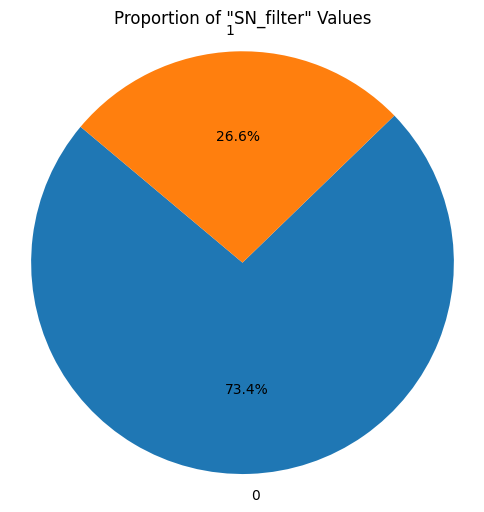

In [ ]:
# Compute the value counts for the "SN_filter" column
value_counts = train_data['SN_filter'].value_counts().compute()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of "SN_filter" Values')
plt.axis('equal')

# Show the pie chart
plt.show()

# **Feature engeneering**

Filter the rows where "SN_filter" is equal to 1



In [ ]:
# Create a copy of train_data
cleaned_train_data = train_data
# Filter the rows where "SN_filter" is equal to 1
cleaned_train_data = train_data[train_data['SN_filter'] == 1]
# Convert the Dask DataFrame to a Pandas DataFrame
cleaned_train_data = cleaned_train_data.compute()

Remove "sequence_id", "dataset_name", "reads", "SN_filter" and "reactivity_error" columns

In [ ]:
# List of columns to remove
columns_to_remove = ["sequence_id", "dataset_name", "reads", "SN_filter"]

# Find columns containing "reactivity_error" in their names
reactivity_error_columns = [col for col in cleaned_train_data.columns if "reactivity_error" in col]

# Combine the columns to remove
columns_to_remove.extend(reactivity_error_columns)

# Drop the specified columns from the DataFrame
cleaned_train_data = cleaned_train_data.drop(columns=columns_to_remove)

For each group of identical sequences, keep only the sequence with the highest signal to noise value

In [ ]:
import pandas as pd

# Create two separate DataFrames based on "experiment_type"
df_2A3_MaP = cleaned_train_data[cleaned_train_data['experiment_type'] == '2A3_MaP']
df_DMS_MaP = cleaned_train_data[cleaned_train_data['experiment_type'] == 'DMS_MaP']

# Delete cleaned_train_data to free space memory
del cleaned_train_data

# Function to keep rows with maximum signal_to_noise within identical sequences
def filter_identical_sequences(df):
    # Group by 'sequence' and keep the row with max 'signal_to_noise'
    filtered_df = df.groupby('sequence').apply(lambda x: x.loc[x['signal_to_noise'].idxmax()])
    return filtered_df

# Filter df_2A3_MaP
df_2A3_MaP = filter_identical_sequences(df_2A3_MaP)

# Filter df_DMS_MaP
df_DMS_MaP = filter_identical_sequences(df_DMS_MaP)

# Concatenate the two data frames
cleared_train_data = pd.concat([df_2A3_MaP, df_DMS_MaP], ignore_index=True)

# Delete df_2A3_MaP and df_DMS_MaP to free space memory
del df_2A3_MaP
del df_DMS_MaP

# Reset the index of the merged data frame
cleared_train_data.reset_index(drop=True, inplace=True)

# Remove the "signal_to_noise" column
cleared_train_data = cleared_train_data.drop(columns=['signal_to_noise'])

Reduce the size of the cleared_train_data. Code inspired from: https://www.kaggle.com/code/saikiranvarma/reduce-memory-of-training-data-by-50

In [ ]:
import numpy as np

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#Reduce memory usage by assigning the real datatypes based on the data
cleared_train_data = reduce_mem_usage(cleared_train_data)

Mem. usage decreased to 325.10 Mb (50.1% reduction)


Save the cleared train data into a csv file

In [ ]:
# Save cleared_train_data as a CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/cleared_train_data.csv'
cleared_train_data.to_csv(csv_path, index=False)

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load cleared_train_data

In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/cleared_train_data.csv'

# Load the CSV file as a Dask DataFrame
cleared_train_data = pd.read_csv(csv_path)

# **Exploratory Data Analysis (EDA)**

RNA Sequence Length Distribution

RNA Sequence Length Distribution
   sequence_length  number_of_sequences
0              115                 2656
1              155                 2011
2              170                14577
3              177               221022
4              206                 2463


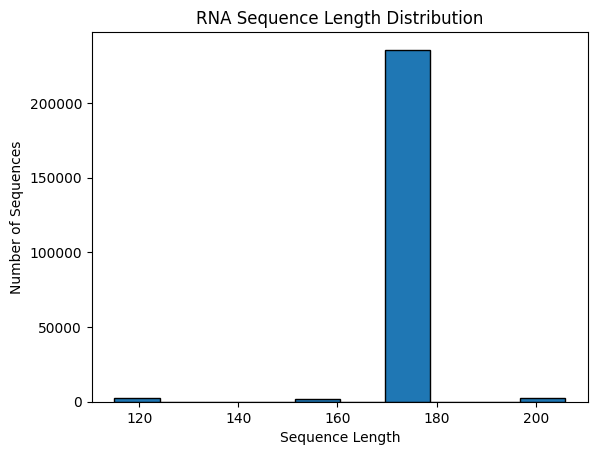

In [ ]:
# Create a DataFrame containing unique sequences
unique_sequences_df = cleared_train_data.drop_duplicates(subset='sequence')

# Calculate the length of each unique sequence and create a histogram
sequence_lengths = unique_sequences_df['sequence'].str.len()

# Plot summary table
table = sequence_lengths.value_counts().sort_index()

# Rename the columns
table = table.reset_index()
table.columns = ['sequence_length', 'number_of_sequences']

# Print or visualize the updated histogram
print("RNA Sequence Length Distribution")
print(table)

# Plot a histogram
# Define the bin width and the number of bins
bin_width = 10  # Adjust this value to change the bin width
num_bins = int((sequence_lengths.max() - sequence_lengths.min()) / bin_width) + 1

# Create the histogram
plt.hist(sequence_lengths, bins=num_bins, edgecolor='k')

# Customize the plot
plt.title("RNA Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Number of Sequences")

# Show the plot
plt.show()

Overall distribution of reactivity values across a random sample of RNA sequences according to the experiment type

In [ ]:
# Filter and create Dask DataFrames with more partitions
dms_map_df = dd.from_pandas(cleared_train_data[cleared_train_data['experiment_type'] == 'DMS_MaP'], npartitions=10)
twoa3_map_df = dd.from_pandas(cleared_train_data[cleared_train_data['experiment_type'] == '2A3_MaP'], npartitions=10)

# Function to create the violin plot using Plotly Express
def create_violin_plot(data, title):
    # Select the columns containing reactivity values
    reactivity_columns = [f'reactivity_{i:04d}' for i in range(1, 207)]

    # Randomly sample a portion of the data
    fraction_to_sample = 0.01
    sampled_data = data.sample(frac=fraction_to_sample, random_state=42)

    # Melt the Dask DataFrame to convert it into long format
    melted_data = sampled_data[reactivity_columns].melt()

    # Create a modern violin plot using Plotly Express
    fig = px.violin(melted_data.compute(), y="value", box=True, points="all", width=800, height=400,
                    title=f"{title}",
                    labels={"value": "Reactivity Value"})

    # Customize the plot appearance
    fig.update_traces(marker=dict(size=3, opacity=0.5), line_color='black')
    fig.update_xaxes(showticklabels=False)

    # Show the plot
    fig.show()

# Create the plot for "DMS_MaP" experiment_type
create_violin_plot(dms_map_df, "Distribution of Reactivity Values for DMS_MaP")

# Create the plot for "2A3_MaP" experiment_type
create_violin_plot(twoa3_map_df, "Distribution of Reactivity Values for 2A3_MaP")

# **Feature engineering**

Perform one-hot encoding for the nucleotides and for each nucleotide, combine with the two reactivity values normalized by robust z-score normalization (it was done in the cluster)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# Define a function to process the entire DataFrame
def process_dataframe(df):
    result_list = []
    unique_sequences = df['sequence'].unique()

    # Create empty lists to store values for robust normalization
    dms_values = []
    a3_values = []

    for sequence in unique_sequences:
        sequence_data = df[df['sequence'] == sequence]
        dms_map_row = sequence_data[sequence_data['experiment_type'] == 'DMS_MaP']
        a3_map_row = sequence_data[sequence_data['experiment_type'] == '2A3_MaP']

        tensor_rows = []
        for i in range(len(sequence)):
            dms_value = dms_map_row[f'reactivity_{i+1:04d}'].iloc[0] if not dms_map_row.empty else np.nan
            a3_value = a3_map_row[f'reactivity_{i+1:04d}'].iloc[0] if not a3_map_row.empty else np.nan
            nucleotide = sequence[i]
            tensor_row = [nucleotide, dms_value, a3_value]
            tensor_rows.append(tensor_row)

            # Append values for robust normalization, only if they are not NaN
            if not np.isnan(dms_value):
                dms_values.append(dms_value)
            if not np.isnan(a3_value):
                a3_values.append(a3_value)

        # Create a DataFrame from the tensor_rows
        tensor_df = pd.DataFrame(tensor_rows, columns=['Nucleotide', 'DMS_MaP_Reactivity', '2A3_MaP_Reactivity'])

        # Perform one-hot encoding for the 'Nucleotide' column
        nucleotide_encoded = pd.get_dummies(tensor_df['Nucleotide'], prefix='Nucleotide')

        # Drop the original 'Nucleotide' column
        tensor_df.drop(columns=['Nucleotide'], inplace=True)

        # Concatenate the one-hot encoded columns with the original DataFrame
        tensor_df = pd.concat([nucleotide_encoded, tensor_df], axis=1)

        result_list.append(tensor_df)

    # Calculate median and Median Absolute Deviation (MAD) for robust normalization
    dms_median = np.nanmedian(dms_values)
    a3_median = np.nanmedian(a3_values)
    dms_mad = np.nanmedian(np.abs(np.array(dms_values) - dms_median))
    a3_mad = np.nanmedian(np.abs(np.array(a3_values) - a3_median))

    # Print the calculated values
    print("dms_median:", dms_median)
    print("a3_median:", a3_median)
    print("dms_mad:", dms_mad)
    print("a3_mad:", a3_mad)

    # Apply robust z-score normalization to all DataFrames
    for i in range(len(result_list)):
        result_list[i]['DMS_MaP_Reactivity'] = (result_list[i]['DMS_MaP_Reactivity'] - dms_median) / (1.482602218505602 * dms_mad)
        result_list[i]['2A3_MaP_Reactivity'] = (result_list[i]['2A3_MaP_Reactivity'] - a3_median) / (1.482602218505602 * a3_mad)

    # Convert each data frame into a NumPy array
    array_list = [df.to_records(index=False) for df in result_list]

    return array_list

# Apply the function to the entire DataFrame
ohe_cleared_train_data = process_dataframe(cleared_train_data)

Save ohe_cleared_train_data

In [ ]:
# Define the output directory
NPY_path = '/content/drive/My Drive/M2BI_DRIVE/ohe_cleared_train_data.npy'
np.save(NPY_path, ohe_cleared_train_data)

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load ohe_cleared_train_data

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats  # Import the stats module for z-score normalization

# Define the path of the CSV file
npy_path = '/content/drive/My Drive/M2BI_DRIVE/ohe_cleared_train_data.npy'

# Load the NPY file
ohe_cleared_train_data = np.load(npy_path, allow_pickle=True)

In [ ]:
ohe_cleared_train_data = ohe_cleared_train_data[0:1000]

Prepare the data and functions for the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
import sys
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

# Define batch size
batch_size = 32

# Split the data into train_data and val_data
split_ratio = 0.8
split_index = int(len(ohe_cleared_train_data) * split_ratio)
X_train = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in ohe_cleared_train_data[:split_index]]
y_train = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in ohe_cleared_train_data[:split_index]]
X_val = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in ohe_cleared_train_data[split_index:]]
y_val = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in ohe_cleared_train_data[split_index:]]

# Create a generator function to yield batches of data with RNA sequence padding
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]

            # Pad RNA sequences to the length of the longest sequence within the batch
            max_length = max(len(seq) for seq in X_batch)
            X_batch = pad_sequences(X_batch, padding='post', dtype='float32', maxlen=max_length)
            y_batch = pad_sequences(y_batch, padding='post', dtype='float32', maxlen=max_length)

            yield X_batch, y_batch

def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# **Model**

In [ ]:
# Create and compile the model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(None, 4)))  # Add the Masking layer
model.add(LSTM(128, return_sequences=True))
model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss=custom_loss)

Visualize the model's structure

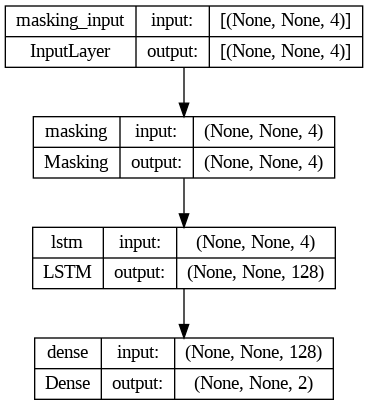

In [ ]:
# Visualize the model's structure
plot_model(model, show_shapes=True, show_layer_names=True)

Fit the model

In [ ]:
# Fit the model using the generator
num_epochs = 10
train_steps = len(X_train) // batch_size
val_steps = len(X_val) // batch_size

# Create lists to store loss, MAE, and RMSE values for training and validation
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_rmses = []
val_rmses = []

train_data_generator = data_generator(X_train, y_train, batch_size)
val_data_generator = data_generator(X_val, y_val, batch_size)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_mae = 0.0
    val_mae = 0.0
    train_rmse = 0.0
    val_rmse = 0.0

    # Redirect stdout to /dev/null
    with open('/dev/null', 'w') as null_file:
        with redirect_stdout(null_file):
            for _ in range(train_steps):
                X_batch, y_batch = next(train_data_generator)
                batch_loss = model.train_on_batch(X_batch, y_batch)

                # Calculate MAE and RMSE separately
                batch_mae = MeanAbsoluteError()(y_batch, model.predict(X_batch))
                batch_rmse = RootMeanSquaredError()(y_batch, model.predict(X_batch))

                # Apply the same masking as in the custom loss function
                nan_mask = tf.math.is_nan(y_batch)
                padded_mask = tf.math.equal(y_batch, 0.0)
                composite_mask = tf.math.logical_or(nan_mask, padded_mask)
                modified_y_batch = tf.where(composite_mask, 0.0, y_batch)

                train_loss += batch_loss
                train_mae += tf.reduce_mean(tf.abs(modified_y_batch - model.predict(X_batch)))
                train_rmse += tf.sqrt(tf.reduce_mean(tf.square(modified_y_batch - model.predict(X_batch))))

            for _ in range(val_steps):
                X_batch, y_batch = next(val_data_generator)
                batch_loss = model.test_on_batch(X_batch, y_batch)

                # Calculate MAE and RMSE separately
                batch_mae = MeanAbsoluteError()(y_batch, model.predict(X_batch))
                batch_rmse = RootMeanSquaredError()(y_batch, model.predict(X_batch))

                # Apply the same masking as in the custom loss function
                nan_mask = tf.math.is_nan(y_batch)
                padded_mask = tf.math.equal(y_batch, 0.0)
                composite_mask = tf.math.logical_or(nan_mask, padded_mask)
                modified_y_batch = tf.where(composite_mask, 0.0, y_batch)

                val_loss += batch_loss
                val_mae += tf.reduce_mean(tf.abs(modified_y_batch - model.predict(X_batch)))
                val_rmse += tf.sqrt(tf.reduce_mean(tf.square(modified_y_batch - model.predict(X_batch))))

    train_maes.append(train_mae / train_steps)
    val_maes.append(val_mae / val_steps)
    train_rmses.append(train_rmse / train_steps)
    val_rmses.append(val_rmse / val_steps)

    train_losses.append(train_loss / train_steps)
    val_losses.append(val_loss / val_steps)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / train_steps}, Validation Loss: {val_loss / val_steps}, Train MAE: {train_mae / train_steps}, Validation MAE: {val_mae / train_steps}, Train RMSE: {train_rmse / train_steps}, Validation RMSE: {val_rmse / val_steps}")

Epoch 1/10, Train Loss: 6.098527555465698, Validation Loss: 8.613669474919638, Train MAE: 1.0560308694839478, Validation MAE: 0.2750324308872223, Train RMSE: 2.4324262142181396, Validation RMSE: 2.92974853515625
Epoch 2/10, Train Loss: 5.989918165206909, Validation Loss: 8.631958961486816, Train MAE: 1.1089221239089966, Validation MAE: 0.27178704738616943, Train RMSE: 2.4115607738494873, Validation RMSE: 2.9338924884796143
Epoch 3/10, Train Loss: 5.89537766456604, Validation Loss: 8.478839000066122, Train MAE: 1.0509545803070068, Validation MAE: 0.25854331254959106, Train RMSE: 2.3918850421905518, Validation RMSE: 2.9072446823120117
Epoch 4/10, Train Loss: 5.788226642608643, Validation Loss: 8.208346366882324, Train MAE: 1.064420223236084, Validation MAE: 0.26436060667037964, Train RMSE: 2.3701436519622803, Validation RMSE: 2.8597419261932373
Epoch 5/10, Train Loss: 5.689052114486694, Validation Loss: 7.919418573379517, Train MAE: 1.0562200546264648, Validation MAE: 0.273930162191391, 

Save the model

In [ ]:
# Save the entire model to a file, including architecture, optimizer, and weights
model.save('/content/drive/My Drive/M2BI_DRIVE/ribonanza_model.keras')

# **Check efficiency of the model**

Plot training loss and validation loss

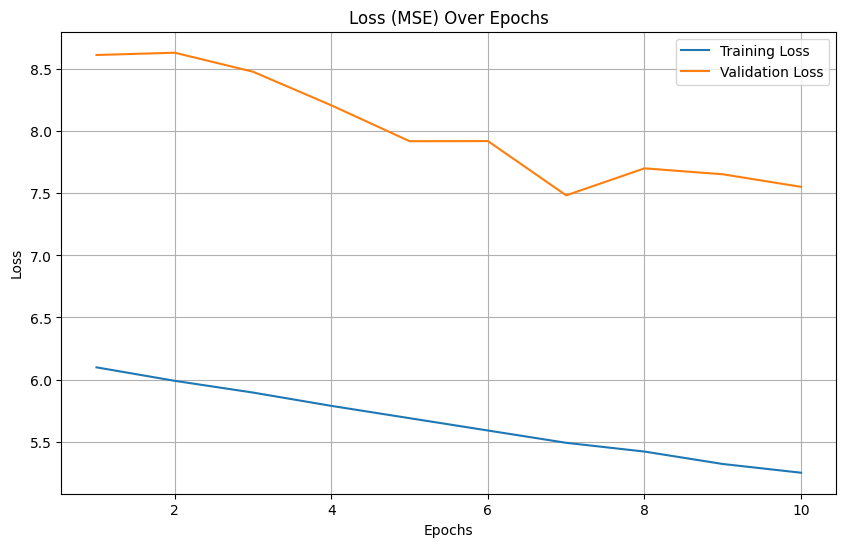

In [ ]:
# Plot Loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (MSE) Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

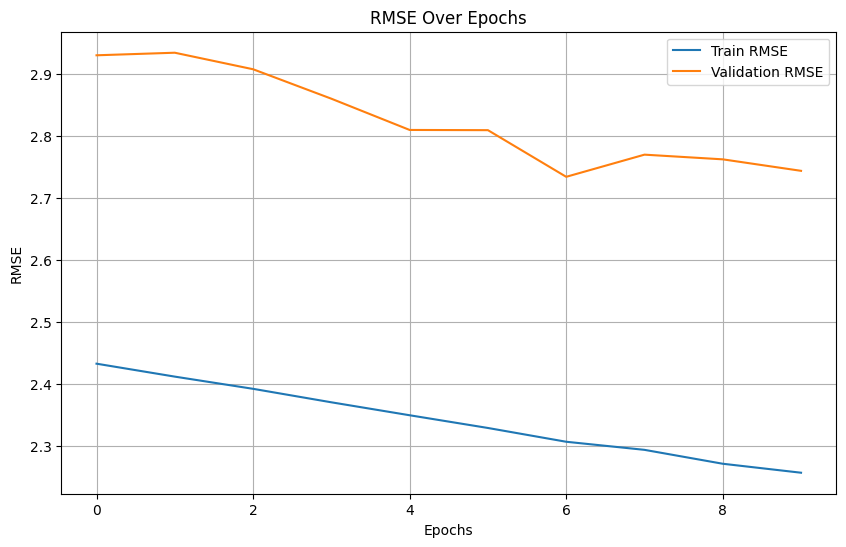

In [ ]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_rmses, label='Train RMSE')
plt.plot(range(num_epochs), val_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.title('RMSE Over Epochs')
plt.show()

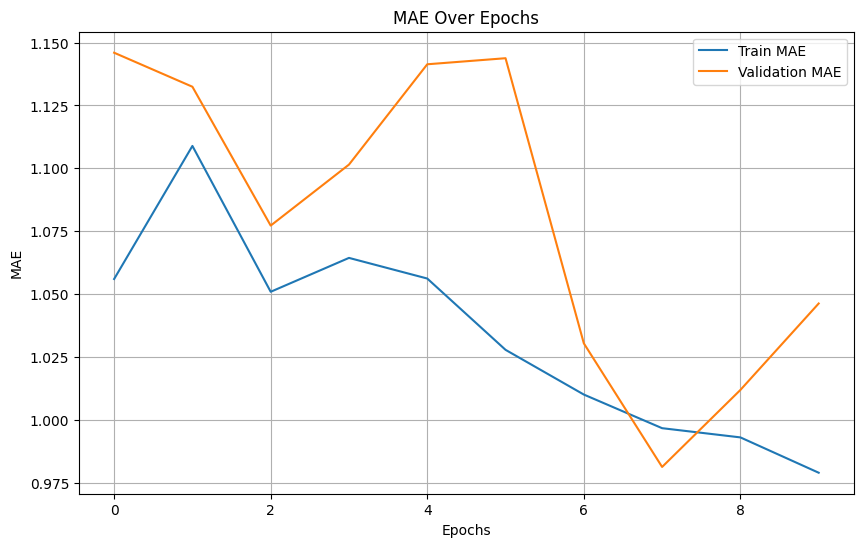

In [ ]:
# Plot MAE
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_maes, label='Train MAE')
plt.plot(range(num_epochs), val_maes, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.title('MAE Over Epochs')
plt.show()

# **Save sample_submission file**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load the model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Define custom loss which is a custom object
def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Define a dictionary of custom objects to be used during model loading
custom_objects = {'custom_loss': custom_loss}

# Load the model from the file, providing the custom_objects dictionary
model = load_model('/content/drive/My Drive/M2BI_DRIVE/ribonanza_model.keras', custom_objects=custom_objects)

# Compile the loaded model with the same optimizer
model.compile(optimizer='adam', loss=custom_loss)

Load test_sequences data

In [ ]:
import pandas as pd

# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/test_sequences.csv'

# Load the CSV file as a Dask DataFrame
test_sequences = pd.read_csv(csv_path)

Generate and save sample_submission.csv

In [ ]:
import pandas as pd
import numpy as np

# Initialize empty lists to store the results
ids = []
reactivity_DMS_MaP_values = []
reactivity_2A3_MaP_values = []

# Define a mapping for nucleotides
nucleotide_mapping = {'A': (0, 0, 1, 0), 'C': (0, 0, 0, 1), 'G': (0, 1, 0, 0), 'U': (1, 0, 0, 0)}

# Initialize id counter
current_id = 0

# Define normalization parameters
dms_median = 0.12
dms_mad = 0.129
a3_median = 0.209
a3_mad = 0.209
robust_constant = 1.482602218505602

# Calculate the scaling factors for reverse normalization
dms_scaling_factor = robust_constant * dms_mad
a3_scaling_factor = robust_constant * a3_mad

# Iterate through each RNA sequence
for idx, sequence in enumerate(test_sequences['sequence']):
    # Initialize empty lists to store sequence-specific results
    sequence_ids = []
    sequence_reactivity_DMS_MaP = []
    sequence_reactivity_2A3_MaP = []

    # Convert the entire RNA sequence to the specified one-hot encoding format
    input_sequence = [nucleotide_mapping.get(nucleotide, (0, 0, 0, 0)) for nucleotide in sequence]

    # Predict reactivity values for the entire RNA sequence using the loaded model
    predicted_values = model.predict(np.array(input_sequence).reshape(1, -1, 4))

    # Iterate through each nucleotide in the sequence and extract the predictions
    for i, nucleotide in enumerate(sequence):
        sequence_ids.append(current_id)
        current_id += 1  # Increment the id

        # Reverse robust z-score normalization for reactivity_DMS_MaP
        reactivity_DMS_MaP = (predicted_values[0, i, 0] * dms_scaling_factor) + dms_median

        # Reverse robust z-score normalization for reactivity_2A3_MaP
        reactivity_2A3_MaP = (predicted_values[0, i, 1] * a3_scaling_factor) + a3_median

        sequence_reactivity_DMS_MaP.append(reactivity_DMS_MaP)
        sequence_reactivity_2A3_MaP.append(reactivity_2A3_MaP)

    # Extend the main lists with sequence-specific results
    ids.extend(sequence_ids)
    reactivity_DMS_MaP_values.extend(sequence_reactivity_DMS_MaP)
    reactivity_2A3_MaP_values.extend(sequence_reactivity_2A3_MaP)

# Create the "sample_submission" DataFrame
sample_submission = pd.DataFrame({
    'id': ids,
    'reactivity_DMS_MaP': reactivity_DMS_MaP_values,
    'reactivity_2A3_MaP': reactivity_2A3_MaP_values
})

# Save the sample_submission DataFrame to a CSV file
sample_submission.to_csv('/content/drive/My Drive/M2BI_DRIVE/sample_submission.csv', index=False)

# **Plot RNA structure**